In [1]:
####
#
# Majority of the code is sampled from https://scikit-learn.org/stable/modules/cross_validation.html 
# it gives a lot of examples and so everything was taken from here. Code taken from other sources will be acknowledged next
# to the code snipets. The part where I was doing code on my own was image augmentation, choosing what hyper-parameters
# value to pick.
#
###

In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, plot_roc_curve, confusion_matrix
from sklearn import datasets, svm, metrics
import pickle
from joblib import dump, load
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier
from skimage.feature import hog
import os

In [2]:
####
#
# Specifying the paths of the datasets and the labels.
#
####

path_train = os.listdir("./nih-malaria/cell_images/train/")
path_val = os.listdir("./nih-malaria/cell_images/val/")
path_test = os.listdir("./nih-malaria/cell_images/test/")
path_full = os.listdir("./nih-malaria/cell_images/")
classes = {'parasitized':0,'uninfected':1}

In [ ]:
####
#
# Loading all images from directory
# Images are converted applied with a HOG feature descriptor and flattened into a 1-D array.
#
####

X=[]
Y=[]

x_train=[]
x_test = []
y_train = []
y_test = []

for cls in classes:
    path_full ="./nih-malaria/"+cls
    for file in os.listdir(path_full):
        img = cv.imread(path_full+'/'+file)
        img = cv.resize(img, (64,128), interpolation = cv.INTER_AREA)
        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8,8),
                            cells_per_block=(2, 2), visualize=True, multichannel=True)

        imgToArr = hog_image.flatten();
        X.append(imgToArr)
        Y.append(classes[cls])

        
print("X: ",len(X))

In [46]:
####
#
# Spliting the total data set for training and testing. Training will recieve 55% of total images and testing will get 30%.
#
####

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .70, test_size=.30 )
print('Test total data:',len(x_test), 'Train total data:',len(x_train))

Test total data: 8268 Train total data: 19290


Label:  0


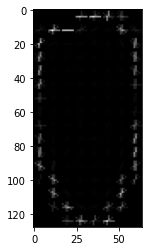

In [47]:
####
#
# Checking if the images are loaded and augmented by reshaping the image.
#
####

img1=x_train[7034].reshape(128,64)
plt.imshow(img1,cmap="gray")
print("Label: ",y_train[2000])


In [48]:
####
#
# Model only takes in data that is a 1-D array. Because the images are in lists, I convert the lists into arrays using
# numpy libary that will convert lists into arrays. The same is done with label lists
#
####

x_train = np.array(x_train,dtype=np.float32)
y_train = np.array(y_train,dtype=np.float32)

x_test = np.array(x_test,dtype=np.float32)
y_test = np.array(y_test,dtype=np.float32)

In [49]:
####
#
# Data normalization scales the values from 0-255 range into a 0-1 value range. This will reduce compuational load as numbers
# can get really big.
#
####

x_test = x_test/255.0
x_train =x_train/255.0

In [49]:
####
#
# The parameters of svm.SVC(kernel='linear') that can be configured
#
####

BaggingClassifier(svm.LinearSVC(class_weight='balanced')).get_params(deep=True)

{'base_estimator__C': 1.0,
 'base_estimator__class_weight': 'balanced',
 'base_estimator__dual': True,
 'base_estimator__fit_intercept': True,
 'base_estimator__intercept_scaling': 1,
 'base_estimator__loss': 'squared_hinge',
 'base_estimator__max_iter': 1000,
 'base_estimator__multi_class': 'ovr',
 'base_estimator__penalty': 'l2',
 'base_estimator__random_state': None,
 'base_estimator__tol': 0.0001,
 'base_estimator__verbose': 0,
 'base_estimator': LinearSVC(class_weight='balanced'),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
####
#
# Grid search will fit a dataset with specified parameters on the estimator 
#
####

param_grid = {'n_estimators':[10,20,15]
             }
grid_search=GridSearchCV(BaggingClassifier(svm.LinearSVC(dual=False)),param_grid,verbose=3,n_jobs=-1)
grid_search.fit(x_test,y_test) 

In [47]:
####
#
# Getting the results of GridSearchCV
#
####

grid_search.best_params_

{'C': 0.001, 'kernel': 'linear'}

In [50]:
####
#
# Defining Bagging ensemble method with estimator and inserting parameters from GrridizedSearchCV.
#
####

clf = OneVsRestClassifier(BaggingClassifier(svm.LinearSVC(dual=False,C=3),n_estimators=10,random_state=0),n_jobs=-1)
clf.fit(x_train,y_train)

OneVsRestClassifier(estimator=BaggingClassifier(base_estimator=LinearSVC(C=3,
                                                                         dual=False),
                                                random_state=0),
                    n_jobs=-1)

In [51]:
####
#
# predictions contain predictions of the given images.
# accuracy show the percentage of how well the labels y_test match the classified predictions values.
#
####

predictions = clf.predict(x_test)
accuracy = accuracy_score(y_test,predictions)
print(accuracy)

0.835752298016449


In [53]:
####
#
# Getting various metrics measurements of how well the model was able to predict test labels
# classes = {'parasitized':0,'uninfected':1}
#
####

labels = ['parasitized','uninfected']
clf_rep = classification_report(y_test,predictions)
print(clf_rep)

              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83      4094
         1.0       0.81      0.87      0.84      4174

    accuracy                           0.84      8268
   macro avg       0.84      0.84      0.84      8268
weighted avg       0.84      0.84      0.84      8268



In [54]:
cm = confusion_matrix(predictions,y_test)
print(cm)

[[3265  529]
 [ 829 3645]]


In [55]:
####
#
# Applying K-fold cross validation to get an average accuracy of predictions using unseen data.
# K-fold cross validation will give a more robust result. Ussualy 3,5,10 folds are most common. 
# Because my testing set is not large I will use 3 folds. The images will be shuffled 
# specifying a number in random_state will give consistent results. For why this happens  
#
# Code is taken from https://scikit-learn.org/stable/modules/cross_validation.html 
#
###

kfold = KFold(n_splits=5, random_state=0,shuffle=True)
accuracies = cross_val_score(clf,x_test,y_test, cv =kfold)

print("5 fold cross validation score: ",accuracies.mean())

5 fold cross validation score:  0.8191831787282073


F:\anacnoda_n\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


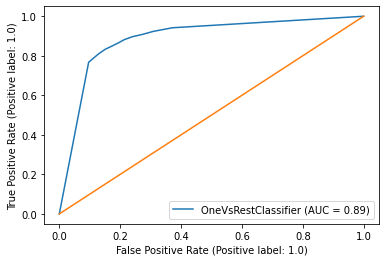

In [56]:
####
#
# Precision = tp/tp+fp - proportion of positive results that were correctly classified
# TPR is the same thing as sensitiviity, tells proportion of a label that were coorectlyclassified
# FPR  is 1-Specificity proportion of incrorectly classified 

plot_roc_curve(clf, x_test, y_test)
plt.plot([0,1])

Predicted value:  1.0
Actual value:  0.0


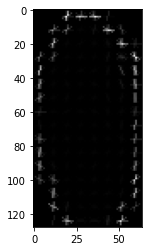

In [62]:
#classes = {'parasitized':0,'uninfected':1}
p=2012
print("Predicted value: ",predictions[p])
print("Actual value: ",y_test[p])

img1=(x_test[p].reshape(128,64))
plt.imshow(img1,cmap="gray")

In [24]:
####
#
# Save the model to reuse later without the need of retraining
#
####

dump(clf, './saved_models/SVM_trained_model_libsvm1.joblib') 

['./saved_models/SVM_trained_model_libsvm1.joblib']

In [ ]:
####
#
# Load a saved model to reuse
#
####

clf = load('./saved_models/SVM_trained_model.joblib') 